In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix




In [3]:
links_df = pd.read_csv('MovieLens_100k/links.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
tags_df = pd.read_csv('MovieLens_100k/tags.csv')

datasets = {
    "Links": links_df,
    "Movies": movies_df,
    "Ratings": ratings_df,
    "Tags": tags_df
}

datasets_info = {name: df.head() for name, df in datasets.items()}
datasets_info

{'Links':    movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
 'Movies':    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
 'Ratings':    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  9

# Exploratory Data Analysis 

In [3]:
# Check for missing values in each dataset
missing_values = {name: df.isnull().sum() for name, df in datasets.items()}

# Print the information about missing values
for name, missing in missing_values.items():
    print(f"Missing values in {name} dataset:\n{missing}\n")

Missing values in Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



In [4]:
# Print the shape of each DataFrame
for name, df in datasets.items():
    print(f"The shape of the {name} DataFrame is: {df.shape}")

The shape of the Links DataFrame is: (9742, 3)
The shape of the Movies DataFrame is: (9742, 3)
The shape of the Ratings DataFrame is: (100836, 4)
The shape of the Tags DataFrame is: (3683, 4)


In [5]:
distribution_of_ratings = ratings_df.groupby('rating').size().reset_index(name='count')
distribution_of_ratings

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


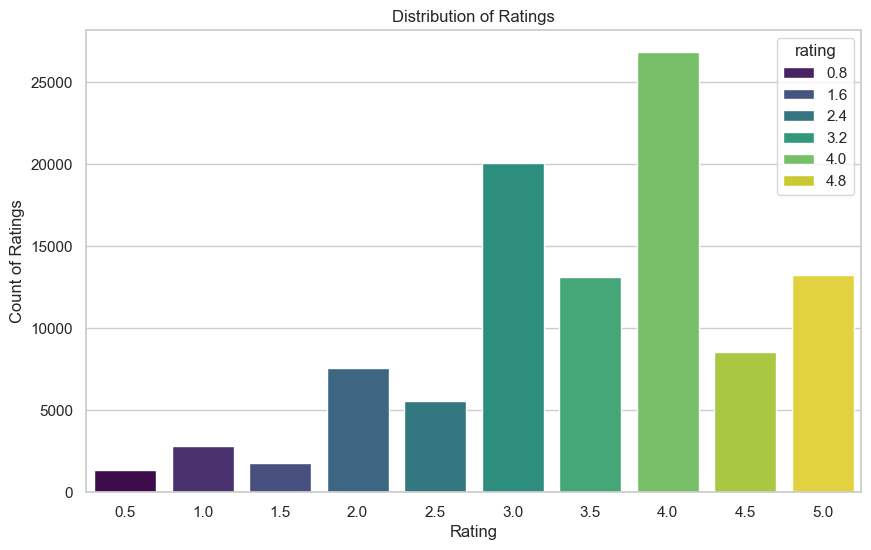

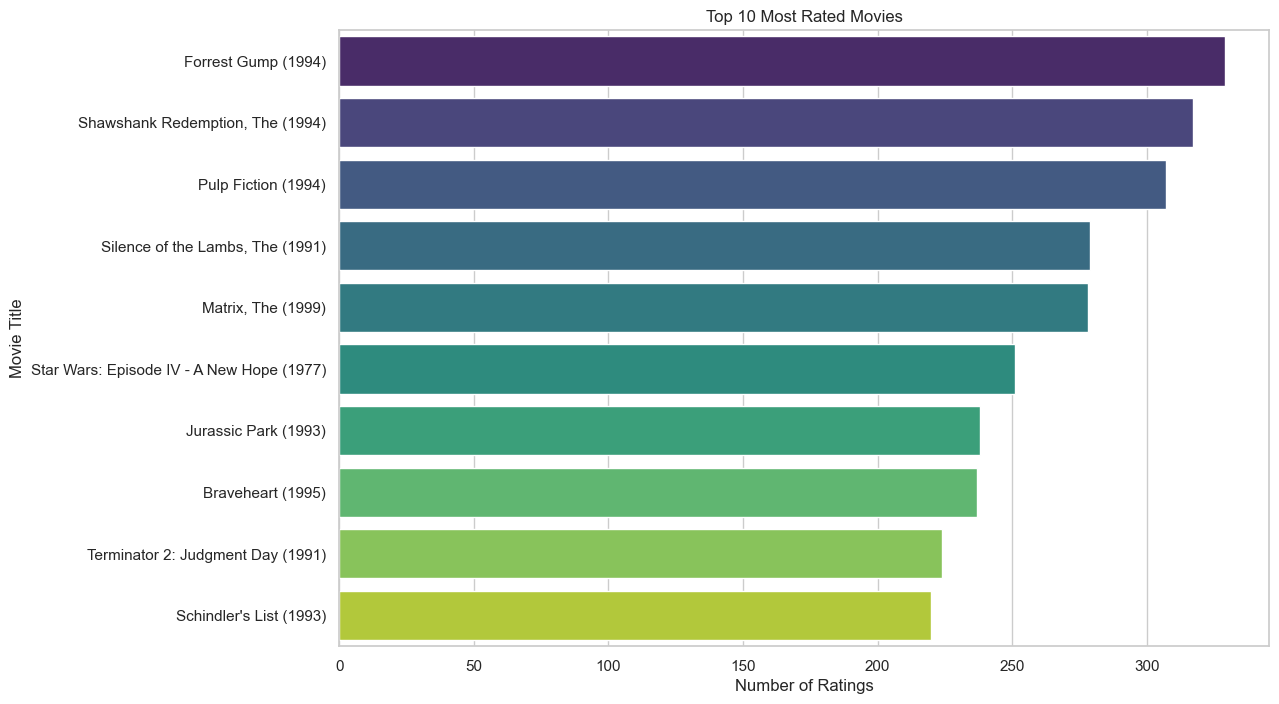

In [7]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis', hue='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of Ratings')
plt.show()

# Finding the most rated movies by merging ratings with movies for better insight
most_rated_movies = ratings_df.groupby('movieId').size().sort_values(ascending=False).head(10).reset_index(name='count')
most_rated_movies = most_rated_movies.merge(movies_df, on='movieId', how='left')

# Plotting the most rated movies
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='title', data=most_rated_movies, palette='viridis', hue='title')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

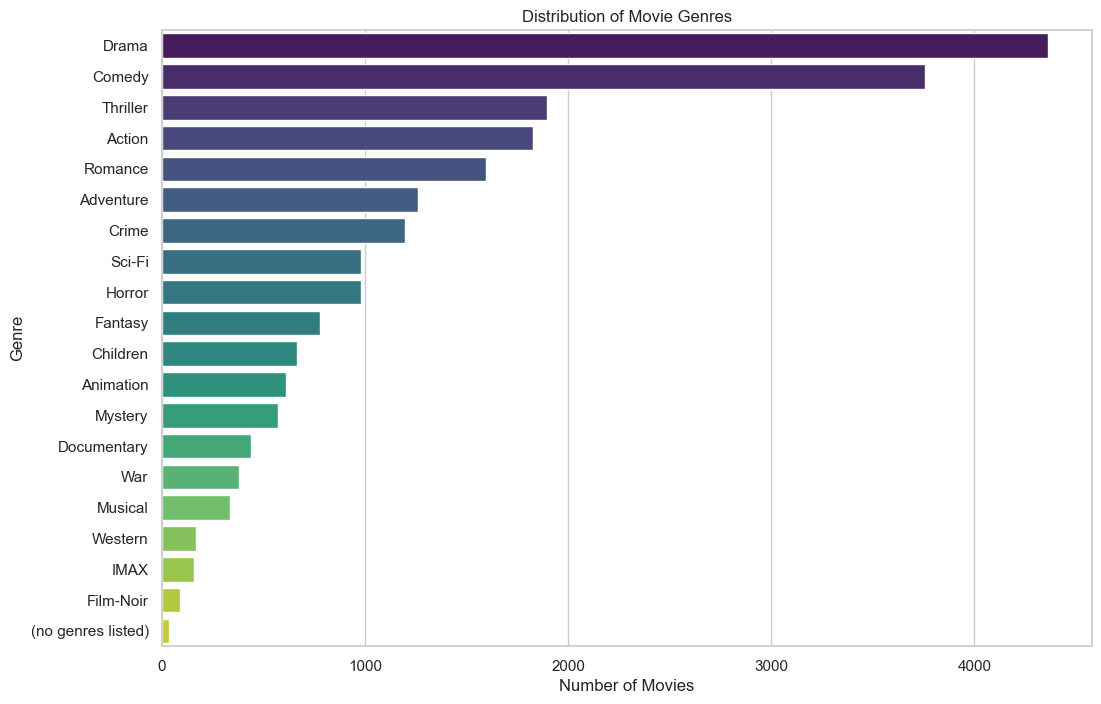

In [8]:
# Split the genres for each movie and count the occurrences of each genre
genre_counts = Counter(g for genres in movies_df['genres'] for g in genres.split('|'))

# Create a dataframe for the genre counts
genres_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plotting the genre distribution
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', data=genres_df, palette='viridis', hue='Genre')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

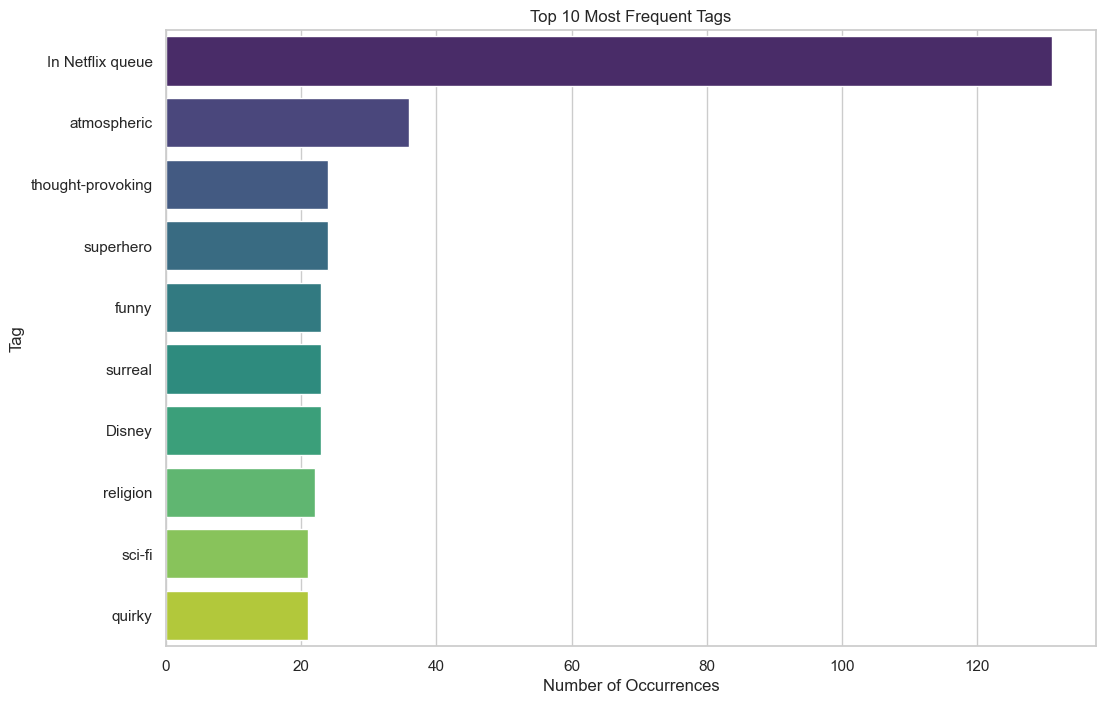

In [9]:
# Count the occurrences of each tag
tag_counts = tags_df['tag'].value_counts().head(10)

# Create a dataframe for the tag counts
tags_count_df = pd.DataFrame({'Tag': tag_counts.index, 'Count': tag_counts.values})

# Plotting the most common tags
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Tag', data=tags_count_df, palette='viridis', hue='Tag')
plt.title('Top 10 Most Frequent Tags')
plt.xlabel('Number of Occurrences')
plt.ylabel('Tag')
plt.show()

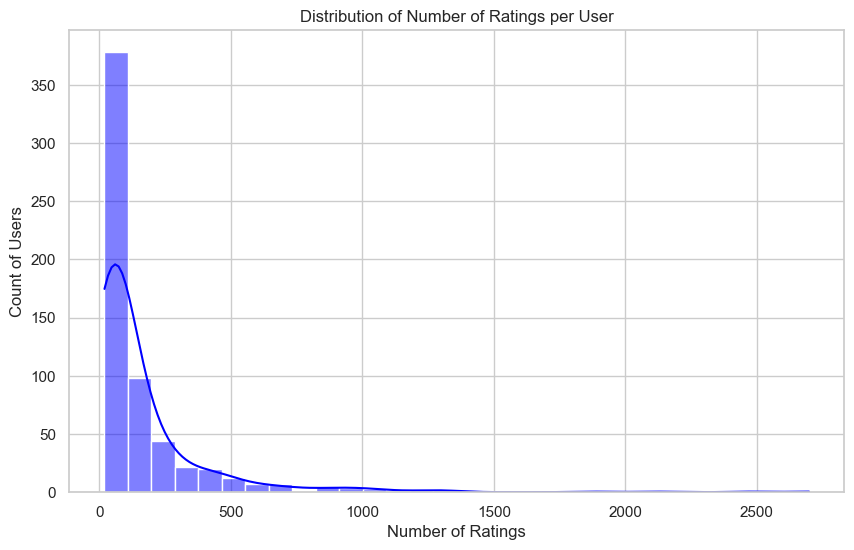

,Number of Ratings,Average Rating
count,610.000000,610.000000
mean,165.304918,3.657222
std,269.480584,0.480635
min,20.000000,1.275000
25%,35.000000,3.360000
50%,70.500000,3.694385
75%,168.000000,3.997500
max,2698.000000,5.000000


In [10]:
# Convert timestamps to datetime for easier manipulation
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# User Interaction Analysis
# Number of ratings per user
ratings_per_user = ratings_df.groupby('userId').size()

# Average rating per user
average_rating_per_user = ratings_df.groupby('userId')['rating'].mean()

# Prepare a DataFrame for user interaction analysis
user_interaction_df = pd.DataFrame({
    'Number of Ratings': ratings_per_user,
    'Average Rating': average_rating_per_user
})

# Basic statistics for user interactions
user_interaction_stats = user_interaction_df.describe()

# Plotting the distribution of number of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True, color='blue')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

user_interaction_stats


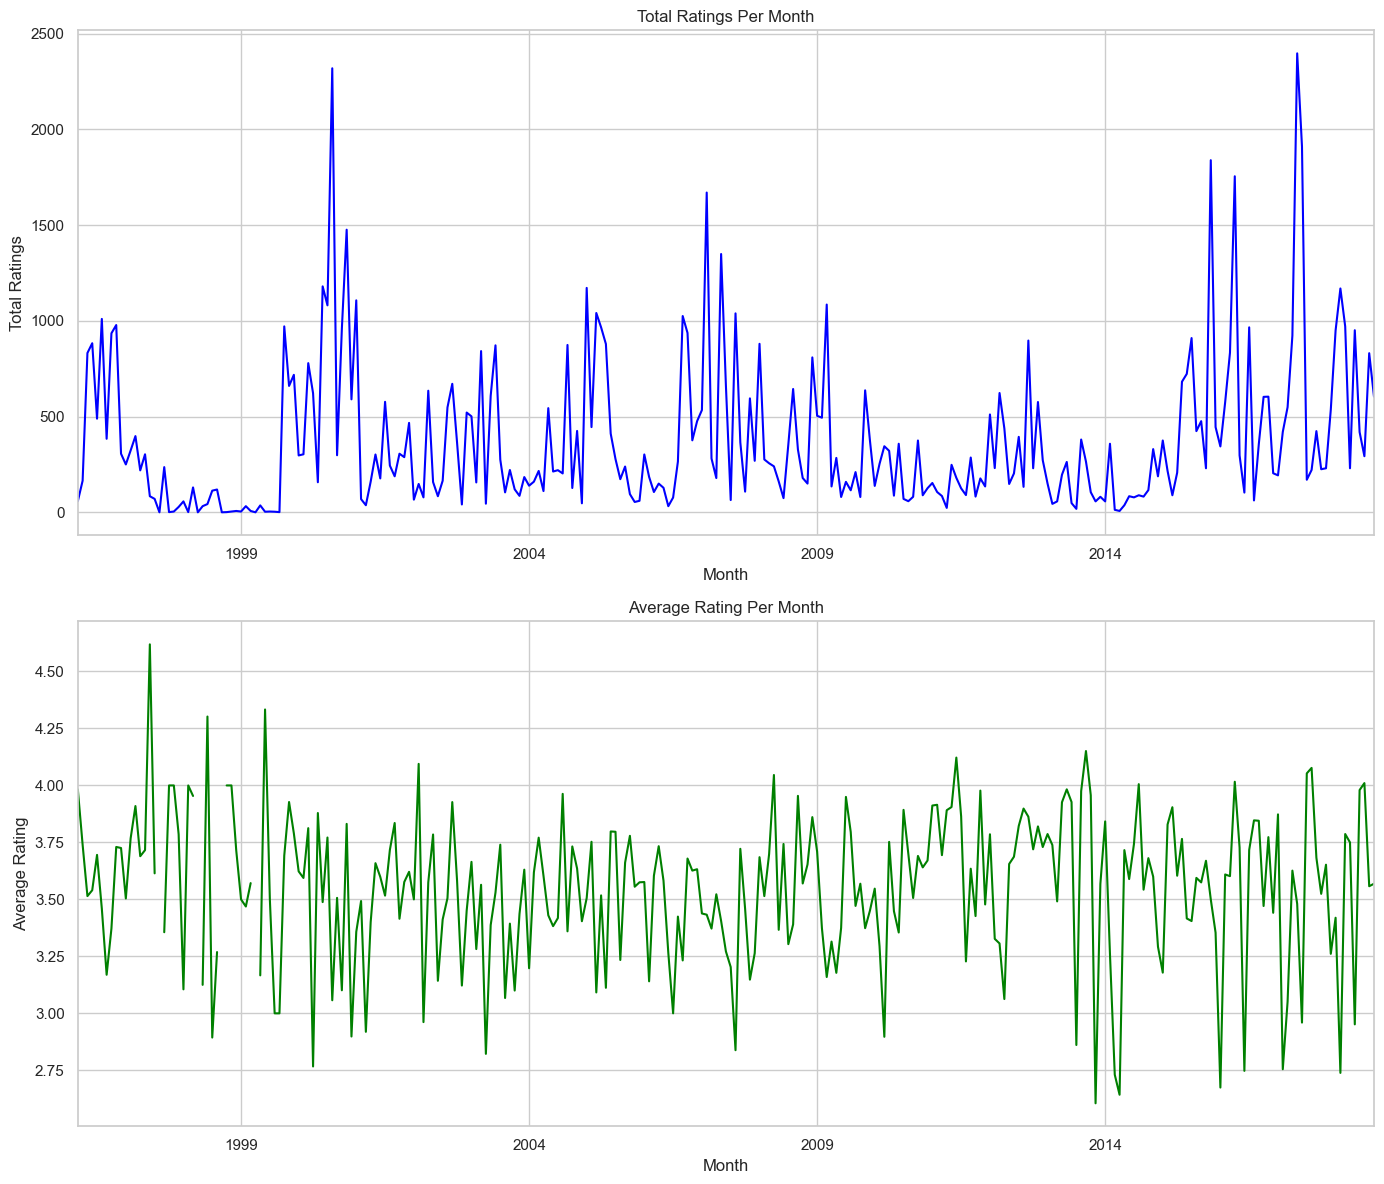

In [11]:
# Ensure the 'timestamp' column is converted to datetime format for temporal analysis
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Aggregate total number of ratings and average ratings per month
ratings_per_month = ratings_df.groupby(pd.Grouper(key='datetime', freq='M')).agg({
    'rating': ['count', 'mean']
}).rename(columns={'count': 'Total Ratings', 'mean': 'Average Rating'})

# Aggregate total number of ratings and average ratings per year
ratings_per_year = ratings_df.groupby(pd.Grouper(key='datetime', freq='Y')).agg({
    'rating': ['count', 'mean']
}).rename(columns={'count': 'Total Ratings', 'mean': 'Average Rating'})

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Monthly ratings
ratings_per_month['rating']['Total Ratings'].plot(ax=ax[0], title='Total Ratings Per Month', color='blue')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Total Ratings')

ratings_per_month['rating']['Average Rating'].plot(ax=ax[1], title='Average Rating Per Month', color='green')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Rating')

plt.tight_layout()
plt.show()


# COLLABORATIVE FILTERINNG 

In [31]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd


# Create a Surprise dataset
reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
train_set, test_set = train_test_split(data, test_size=0.20)

# Output to check
train_set.n_ratings, len(test_set)

(80668, 20168)

In [47]:
from surprise import KNNBasic
from surprise.accuracy import rmse,mae

# Compute cosine similarity between items
sim_options = {
    'name': 'cosine',
    'user_based': False  # Compute similarities between items
}
model = KNNBasic(sim_options=sim_options)

# Train the model
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(test_set)

# Evaluate accuracy
rmse_score = rmse(predictions)
mae_score= mae(predictions)
print(f'RMSE: {rmse_score}')
print(f'RAE: {mae_score}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9164
MAE:  0.7089
RMSE: 0.9163885770566904
RAE: 0.7088840642291676


In [44]:
from collections import defaultdict
from surprise import accuracy

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Map the predictions to only the top N items
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user."""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Use the trained model to predict ratings for the testset
predictions = model.test(testset)

# Retrieve the top-10 recommendations for each user
top_n = get_top_n(predictions, n=10)

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# Calculate average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')

Average Precision: 0.5930
Average Recall: 0.4740


In [42]:
def get_top_n_recommendations(user_id, n=10):
    # Get a list of all movies in the dataset
    all_movies = movies_df['movieId'].unique()
    
    # Get movies that the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    
    # Predict ratings for all movies the user hasn't rated yet
    predictions = []
    for movie_id in set(all_movies) - set(rated_movies):
        pred = model.predict(uid=user_id, iid=movie_id)
        predictions.append((movie_id, pred.est))
    
    # Sort the predictions by estimated rating in descending order and select the top N
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    # Map the movie IDs back to titles
    top_n_movies = [(movies_df[movies_df['movieId'] == mid]['title'].values[0], est) for mid, est in top_n]
    
    return top_n_movies

# Example usage: Recommend top 10 movies for user with ID 1
recommended_movies = get_top_n_recommendations(user_id=40, n=10)
recommended_movies

[('Cry, the Beloved Country (1995)', 5.0),
 ('Byzantium (2012)', 5.0),
 ('Endless Poetry (2016)', 5.0),
 ('Thin Line Between Love and Hate, A (1996)', 5.0),
 ('The Jinx: The Life and Deaths of Robert Durst (2015)', 5.0),
 ('Last Klezmer: Leopold Kozlowski, His Life and Music, The (1994)', 5.0),
 ("Divorce - Italian Style (Divorzio all'italiana) (1961)", 5.0),
 ('Afro Samurai: Resurrection (2009)', 5.0),
 ('Single Girl, A (Fille seule, La) (1995)', 5.0),
 ('Hustler White (1996)', 5.0)]

# Graph based RecSys

In [49]:
from igraph import Graph

# Create a list of tuples representing edges between users and movies
edges = [(int(row['userId']), int(row['movieId'])) for _, row in ratings_df.iterrows()]

# Create lists of unique nodes for users and movies
user_nodes = [int(user) for user in ratings_df['userId'].unique()]
movie_nodes = [int(movie) + max(user_nodes) + 1 for movie in movies_df['movieId'].unique()]

# Combine all nodes and their types (0 for users, 1 for movies)
nodes = user_nodes + movie_nodes
types = [0] * len(user_nodes) + [1] * len(movie_nodes)

# Create the igraph graph
g = Graph(edges=edges, directed=False)

# Set attributes for nodes (vertex)
g.vs['type'] = types  # Type for bipartite identification
g.vs['name'] = nodes  # Unique identifier

# Add edge weights based on ratings
g.es['weight'] = [float(row['rating']) for _, row in ratings_df.iterrows()]

# Display basic information about the graph
print(g.summary())

IGRAPH UNWT 193610 100836 -- 
+ attr: name (v), type (v), weight (e)
